<a href="https://colab.research.google.com/github/fintechsteve/modeling-volatility/blob/master/Part_04b_Creating_Turbulence_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Part 05 (b): Creating a GARCH Model

### In this section you will:


*   Load volatility forecasts with a rolling window.
*   Transform the forecasts into set of dynamic weights and track performance of the model.



## Import all necessary libraries

For this piece, we will need the following packages to be available to our environment:

*   Numpy and Pandas (For data manipulation)
*   DateTime (For basic date manipulation)
*   Matplotlib (For timeseries vizualization)

If the packages are not available, install the with "pip install X"

In [1]:
import numpy as np, pandas as pd
from datetime import datetime, timedelta
import pickle
import cloudpickle as cp
import urllib.request, urllib.parse, urllib.error
import matplotlib.pyplot as plt
import bisect
from scipy import stats
import seaborn as sns

In [2]:
with open('./returns.pkl', 'rb') as f:
  returns = pickle.load(f)
  f.close()

### Read in data from previously stored vol_pred.pkl file



In [ ]:
df_vol_pred = cp.load(urllib.request.urlopen('https://github.com/fintechsteve/modeling-volatility/blob/master/vol_pred.pkl?raw=true'))

Alternatively, if you have estimated the models locally.

In [58]:
with open('./vol_pred.pkl', 'rb') as f:
    df_vol_pred = pickle.load(f)
    f.close()

In [59]:
df_vol_pred.head(10)

,date,p,q,var
0,1975-12-30,1,1,0.017347
1,1975-12-31,1,1,0.016462
2,1976-01-01,1,1,0.015340
3,1976-01-02,1,1,0.014118
4,1976-01-05,1,1,0.015978
5,1976-01-06,1,1,0.015826
6,1976-01-07,1,1,0.015384
7,1976-01-08,1,1,0.015142
8,1976-01-09,1,1,0.025546
9,1976-01-12,1,1,0.024581


Plot p = 2, q = 3 as an example.

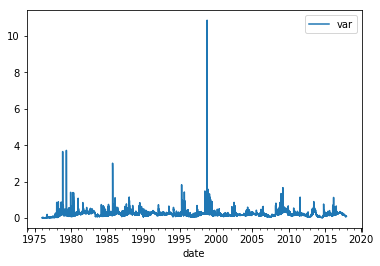

In [60]:
vol_pred_23 = df_vol_pred[(df_vol_pred['p']==2) & (df_vol_pred['q']==3)][['date', 'var']]
vol_pred_23 = vol_pred_23.set_index('date')
vol_pred_23.plot()

### Convert rolling volatility forecast into a weight 

We are going to use linear ranking to create weights, just as we did for the Turbulence signal.

The linear ranking, when used in-sample, should map results to a uniform distribution.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4fae883550>]],
      dtype=object)

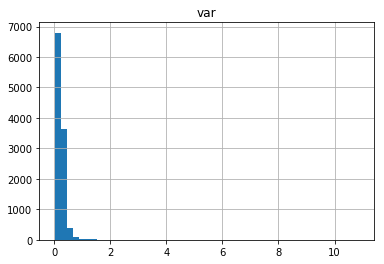

In [61]:
vol_pred_23.hist(bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4fae7ef438>]],
      dtype=object)

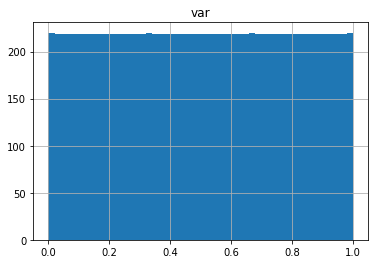

In [62]:
vol_pred_23_rank = vol_pred_23.dropna().rank()/vol_pred_23.count()
vol_pred_23_rank.hist(bins=50)

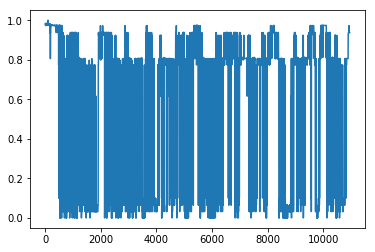

In [63]:
insample_start_date = '1975-12-30'
insample_end_date = '2000-01-01'
insample_vol_pred_23 = (vol_pred_23.loc[insample_start_date:insample_end_date]).dropna().values
insample_vol_pred_23.sort()
num_insample = np.size(insample_vol_pred_23)
vol_pred_23_ranked = 1-np.true_divide(list(map(lambda x:float('NaN') if np.isnan(x) else bisect.bisect_left(insample_vol_pred_23,x), vol_pred_23['var'])),num_insample)
plt.plot(vol_pred_23_ranked)


In [64]:
def garch_weights(vol, insample_start_date, insample_end_date):
  insample_vol = (vol.loc[insample_start_date:insample_end_date]).dropna().values
  insample_vol.sort()
  num_insample = np.size(insample_vol)
  vol_weights = pd.DataFrame(1-np.true_divide(list(map(lambda x:float('NaN') if np.isnan(x) else bisect.bisect_left(insample_vol,x), vol['var'])),num_insample), index=vol.index)
  vol_weights.columns=['weights']
  return vol_weights

In [65]:
vol_weights = garch_weights(vol_pred_23, '1975-12-30', '2000-01-01')
vol_weights.head(20)

,weights
date,
1975-12-30,0.982439
1975-12-31,0.983397
1976-01-01,0.983397
1976-01-02,0.983557
1976-01-05,0.983397
1976-01-06,0.983397
1976-01-07,0.983397
1976-01-08,0.983557
1976-01-09,0.973978


### Quick sanity checks

1) Are the weights aligned with decreasing volatility?
2) Does the weight inversely correlate with subsequent volatility?

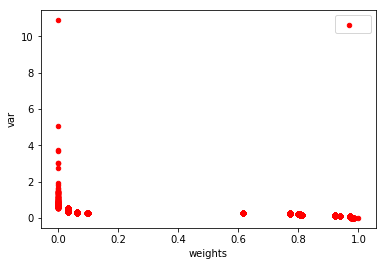

In [66]:
pd.concat([vol_pred_23, vol_weights],axis=1).plot(kind='scatter', x='weights', y='var',
                                           color='Red', label='')

In [67]:
dxy_weight = [0, 0.119, 0.036, 0, 0.136, 0.576, 0, 0, 0.091]
dxy = pd.DataFrame(returns.dot(dxy_weight))
dxy_trunc = dxy[insample_start_date:'2017-12-22'] ##the last few days are missing?, I need to redo the GARCH stuff to get the last couple days
dxy_forward = dxy_trunc.shift(-1)
dxy_forward_sq = (dxy_forward**2).rename(columns={0:'dxyfsq'})

In [68]:
highvol = vol_weights['weights']<.25
pd.DataFrame([[np.sqrt(261)*dxy_trunc[highvol].std(), np.sqrt(261)*dxy_trunc[~highvol].std()], [sum(highvol), sum(~highvol)]], index=['std','N'], columns=['High Vol','Low Vol'])

,High Vol,Low Vol
std,0 0.106796 dtype: float64,0 0.062351 dtype: float64
N,2776,8178


### Calculate the performance of the GARCH model

Leveraging the framework we developed in Part 3, we calculate the excess performance of the model.


In [69]:
def model_perf(model_wts, dxyfsq, framework_params):
  # Note, since chapter 3, modified the code a little to handle the possibility that column headings are not constant
  # Also added an estimation window, which we will use later
    
  model_vol = pd.DataFrame()
  model_vol['total'] = model_wts[model_wts.columns[0]]*dxyfsq[dxyfsq.columns[0]] 
  model_vol['avg'] = (np.mean(model_wts.loc[framework_params['insample_start_date']:framework_params['insample_end_date']].dropna()[model_wts.columns[0]])*dxyfsq)

  is_model_vol = model_vol.loc[framework_params['insample_start_date']:framework_params['insample_end_date']].dropna() 
  is_vol_rmse = np.sqrt(np.mean(is_model_vol))

  out_model_vol = model_vol.loc[framework_params['outofsample_start_date']:framework_params['outofsample_end_date']].dropna()
  out_vol_rmse = np.sqrt(np.mean(out_model_vol))
  
  model_perf_stats = {'insample rmse': is_vol_rmse['total'], 'insample excess rmse': is_vol_rmse['total'] - is_vol_rmse['avg'],
                        'out-of-sample rmse': out_vol_rmse['total'], 'out-of-sample excess rmse': out_vol_rmse['total'] - out_vol_rmse['avg']}
    
  if framework_params.get('estimationsample_start_date'):
    est_model_vol = model_vol.loc[framework_params['estimationsample_start_date']:framework_params['estimationsample_end_date']].dropna()
    est_vol_rmse = np.sqrt(np.mean(est_model_vol))
    model_perf_stats['estimation rmse'] = est_vol_rmse['total']
    model_perf_stats['estimation excess rmse'] = est_vol_rmse['total'] - est_vol_rmse['avg']
        
  if framework_params.get('verbose',False):
    model_perf_stats['insample model volatility'] = is_model_vol
    model_perf_stats['out-of-sample model volatility'] = out_model_vol
    
  return model_perf_stats

In [70]:
framework_params = {'insample_start_date': '1975-12-30',
                    'insample_end_date': '2000-01-01',
                    'outofsample_start_date': '2000-01-02',
                    'outofsample_end_date': '2017-12-22',
                    'verbose': False}

model_perf_stats = model_perf(vol_weights, dxy_forward_sq, framework_params)
model_perf_stats

{'insample rmse': 0.003393433958934961,
 'insample excess rmse': -0.0004135672302842449,
 'out-of-sample rmse': 0.003478637153671608,
 'out-of-sample excess rmse': -9.692991667869296e-06}

### Test significance of excess volatility

A simple test of the ability of a turbulence model to outperform a random model is to calculate the significance of the average excess volatility.

We want this statistic to be negative, because a good model should reduce volatility.

We can calculate this by looking at the difference between the volatility for the model and the volatility of a model that assigns an average weight to volatility and calculating a t-statistic:

In [71]:
framework_params = {'insample_start_date': '1975-01-02',
                    'insample_end_date': '2000-01-01',
                    'outofsample_start_date': '2000-01-02',
                    'outofsample_end_date': '2017-12-22',
                    'verbose': True}

model_perf_stats = model_perf(vol_weights, dxy_forward_sq, framework_params)

stats.ttest_rel(model_perf_stats['insample model volatility']['total'], model_perf_stats['insample model volatility']['avg'])


Ttest_relResult(statistic=-8.08224577919555, pvalue=7.569253020103589e-16)

In [72]:
stats.ttest_rel(model_perf_stats['out-of-sample model volatility']['total'], model_perf_stats['out-of-sample model volatility']['avg'])

Ttest_relResult(statistic=-0.2101924552809647, pvalue=0.8335266022422361)

### Grid search for the optimal parameters

We have been working with the GARCH model with p = 2 and q = 3. How do we pick the correct parameters?

### Splitting the sample for hyperparameter tuning


In [82]:
framework_params = {'insample_start_date': '1975-12-30',
                    'insample_end_date': '1994-12-31',
                    'estimationsample_start_date': '1995-01-01',
                    'estimationsample_end_date': '2004-12-31',
                    'outofsample_start_date': '2005-01-01',
                    'outofsample_end_date': '2017-12-22',
                    'verbose': False}

def garch_models_performance(vol_signal, framework_params):
  vol_wts = garch_weights(vol_signal, framework_params['insample_start_date'], framework_params['insample_end_date'])
  model_perf_stats = model_perf(vol_wts, dxy_forward_sq, framework_params)
  return {'model_perf_stats':model_perf_stats, 'vol_wts':vol_wts}

some_model_perf_stats = garch_models_performance(vol_pred_23, framework_params)
some_model_perf_stats['model_perf_stats']

{'insample rmse': 0.003302291551282418,
 'insample excess rmse': -0.000318260336367936,
 'out-of-sample rmse': 0.00331002884074875,
 'out-of-sample excess rmse': -0.00012650512241484547,
 'estimation rmse': 0.003490040287147398,
 'estimation excess rmse': -0.00015044772230775848}

We will run for p=1, 2, and 3 and q = 1, 2, and 3


In [103]:
ps = [1, 2, 3]
qs = [1, 2, 3]

index = pd.MultiIndex.from_product([ps,qs],names=['p','q'])

garch_model_perf_stats = pd.DataFrame(index = index, columns = some_model_perf_stats['model_perf_stats'].keys())
garch_model_weights = pd.DataFrame(index = returns.index, columns = index)

for p in ps:
  for q in qs:
    vol_pred = df_vol_pred[(df_vol_pred['p']==p) & (df_vol_pred['q']==q)][['date', 'var']]
    vol_pred = vol_pred.set_index('date')
    model_output = garch_models_performance(vol_pred, framework_params)
    garch_model_perf_stats.loc[(p,q)] = model_output['model_perf_stats']
    garch_model_weights.loc[:,(p,q)] = model_output['vol_wts']['weights']

CPU times: user 1.45 s, sys: 16.5 ms, total: 1.47 s
Wall time: 1.46 s


In [104]:
garch_model_perf_stats

insample rmse insample excess rmse out-of-sample rmse  \
p q                                                         
1 1    0.00324831         -0.000307514         0.00323501   
  2    0.00321154         -0.000333231         0.00322812   
  3    0.00331766         -0.000325795         0.00335329   
2 1    0.00324885         -0.000318367          0.0032642   
  2      0.003321         -0.000316347         0.00332277   
  3    0.00330229          -0.00031826         0.00331003   
3 1    0.00328706         -0.000299918         0.00329972   
  2    0.00339708         -0.000286739         0.00337035   
  3    0.00339505         -0.000274695         0.00336567   

    out-of-sample excess rmse estimation rmse estimation excess rmse  
p q                                                                   
1 1               -0.00014009      0.00346449           -0.000110918  
  2              -0.000136487      0.00343909           -0.000125198  
  3              -0.000104983      0.00352913           -0.000134386  
2 1              -0.000121714      0.00346633           -0.000120532  
  2              -0.000129708      0.00351356           -0.000143819  
  3              -0.000126505      0.00349004           -0.000150448  
3 1              -0.000104948       0.0034509           -0.000155831  
  2              -0.000126234       0.0035261           -0.000178003  
  3              -0.000117558      0.00349212           -0.000197838

In [105]:
garch_model_weights.to_pickle('./garch_model_weights.pkl')
garch_model_perf_stats.to_pickle('./garch_model_perf_stats.pkl')

### Out of sample performance evaluation

Evaluating the out of sample performance of the optimal model
We plan on taking the model with the lowest estimation period excess RMSE as the optimal parameterization.

Let's look at how well this aligns during the out of sample period.

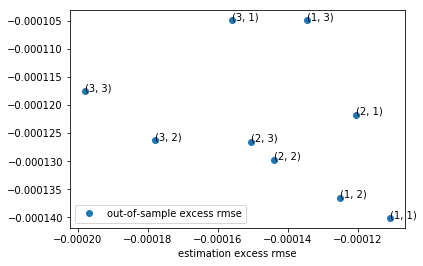

In [107]:
fig, ax = plt.subplots()
garch_model_perf_stats.plot(x='estimation excess rmse', y='out-of-sample excess rmse', ax=ax, style='o')

for k, v in garch_model_perf_stats.iterrows():
  ax.annotate(k, (v['estimation excess rmse'],v['out-of-sample excess rmse']))

And again, plotting the insample and out of sample excess RMSE to explore the overfitting problem:

Hint: It's worse for GARCH...

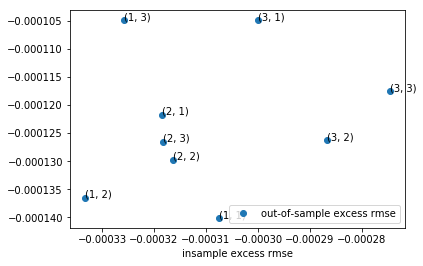

In [108]:
fig, ax = plt.subplots()
garch_model_perf_stats.plot(x='insample excess rmse', y='out-of-sample excess rmse', ax=ax, style='o')

for k, v in garch_model_perf_stats.iterrows():
  ax.annotate(k, (v['insample excess rmse'],v['out-of-sample excess rmse']))